# Running across mice mean trace FOR SHAPING PHASE - 1.5 seconds baseline mean is subtracted from all mice's individual traces seperatedly then aggregated again to reduce overall noise

In [34]:
import os
import numpy as np
import pandas as pd
import scipy.stats
from nptdms import TdmsFile
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def import_photometry_data(directory, mouse_id, day):
    """
    Import photometry data for a given mouse and day.
    
    Parameters:
    - directory: str. The directory where the TDMS files are stored.
    - mouse_id: str. The unique identifier for the mouse.
    - day: int. The day of interest.
    
    Returns:
    - dict: A dictionary with channel names as keys and numpy arrays of data as values, or None if the file cannot be read.
    """
    filename = os.path.join(directory, f"{mouse_id}_day{day}.tdms")
    if not os.path.exists(filename):
        print(f"File {filename} does not exist.")
        return None
    try:
        tdms_file = TdmsFile.read(filename)
    except Exception as e:
        print(f"Failed to read {filename}: {e}")
        return None

    return {channel.name: channel[:] for group in tdms_file.groups() for channel in group.channels()}

def load_and_preprocess_behavior_data(directory, mouse_id, day):
    """
    Load and preprocess behavior data from LVM files.
    
    Parameters:
    - directory: str. The directory where the LVM files are stored.
    - mouse_id: str. The unique identifier for the mouse.
    - day: int. The day of interest.
    
    Returns:
    - DataFrame: A pandas DataFrame with behavior data, or None if the file cannot be read.
    """
    filepath = os.path.join(directory, f"{mouse_id}_day{day}.lvm")
    if not os.path.exists(filepath):
        print(f"File {filepath} does not exist.")
        return None

    data = pd.read_csv(filepath, header=None)
    columns = ['time', 'odour_a', 'odour_b', 'odour_c', 'lick_data', 'water_valve']
    data.columns = columns[:len(data.columns)]
    return data.dropna(axis=1, how='all')

def find_water_valve_rises(signal):
    """
    Identify indices where the water valve signal rises above a threshold.
    
    Parameters:
    - signal: array-like. The water valve signal data.
    
    Returns:
    - ndarray: Indices of signal rise points.
    """
    return np.where(np.diff(signal > 2))[0] + 1

def process_photometry_data(directory_photometry, directory_behavior, mouse_id, day):
    """
    Process photometry and behavior data for a given mouse and day.
    
    Parameters:
    - directory_photometry: str. Directory containing photometry data files.
    - directory_behavior: str. Directory containing behavior data files.
    - mouse_id: str. The unique identifier for the mouse.
    - day: int. The day of interest.
    
    Returns:
    - dict: A dictionary with brain areas as keys and lists of signal segments as values.
    """
    sampling_rate = 500  # Hz
    pre_reward_secs, post_reward_secs = 10, 5
    baseline_pre_reward_secs = 1.5

    photometry_data = import_photometry_data(directory_photometry, mouse_id, day)
    behavior_data = load_and_preprocess_behavior_data(directory_behavior, mouse_id, day)
    if photometry_data is None or behavior_data is None:
        print(f"Failed to load data for mouse {mouse_id}.")
        return None

    reward_indices = find_water_valve_rises(behavior_data['water_valve'].values)
    pre_reward_points, post_reward_points = int(pre_reward_secs * sampling_rate), int(post_reward_secs * sampling_rate)
    baseline_pre_reward_points = int(baseline_pre_reward_secs * sampling_rate)

    ach_signals = {'PFC': [], 'HPC': []}
    for reward_index in reward_indices:
        for area, channel_name in zip(['PFC', 'HPC'], ['Voltage_0 (Filtered)', 'Voltage_1 (Filtered)']):
            if channel_name in photometry_data:
                start, end = max(reward_index//2 - pre_reward_points, 0), reward_index//2 + post_reward_points
                baseline_start = reward_index//2 - baseline_pre_reward_points
                segment = photometry_data[channel_name][start:end]
                if len(segment) == pre_reward_points + post_reward_points:
                    baseline_mean = np.mean(photometry_data[channel_name][baseline_start:reward_index//2])
                    ach_signals[area].append(segment - baseline_mean)
    return ach_signals

def plot_area_signals(area, signal_list, time_axis, colors, day_of_interest, added_legends):
    """
    Plot the signals for a given area with vertical lines indicating events,
    ensuring no duplicate legend entries for overlaid plots.
    
    Parameters:
    - area (str): Brain area to plot.
    - signal_list (list): List of signals for the area.
    - time_axis (np.ndarray): Time axis for the plot.
    - colors (dict): Dictionary mapping areas to colors.
    - day_of_interest (int): Day of interest for the title.
    - added_legends (set): A set to track which legend entries have been added to avoid duplicates.
    """
    signals_stack = np.vstack(signal_list)
    mean_signal = np.mean(signals_stack, axis=0)
    sem_signal = scipy.stats.sem(signals_stack, axis=0)
    color = colors.get(area, 'black')

    label = f'{area} Mean Signal'
    if label not in added_legends:
        plt.plot(time_axis, mean_signal, label=label, color=color, linewidth=2)
        added_legends.add(label)
    else:
        plt.plot(time_axis, mean_signal, color=color, linewidth=2)

    plt.fill_between(time_axis, mean_signal - sem_signal, mean_signal + sem_signal, alpha=0.2, color=color)

    # Handle vertical lines and their legend entries
    events = [
        (0, 'red', 'Reward Onset'),
        (-2.5, 'purple', 'Second Odour Onset'),
        (-8.5, 'magenta', 'First Odour Onset'),
    ]
    for x, color, label in events:
        if label not in added_legends:
            plt.axvline(x=x, color=color, linestyle='--', linewidth=2, label=label)
            added_legends.add(label)
        else:
            plt.axvline(x=x, color=color, linestyle='--', linewidth=2)



def plot_signals(signals, pre_reward_secs, post_reward_secs, mouse_ids, overlay, day_of_interest):
    """
    Plot signals for each brain area, with options to overlay signals and adjust for day of interest.
    
    Parameters:
    - signals (dict): Dictionary with brain areas as keys and signal arrays as values.
    - pre_reward_secs (int): Seconds before reward to include in the plot.
    - post_reward_secs (int): Seconds after reward to include in the plot.
    - mouse_ids (list): List of mouse identifiers.
    - overlay (bool): Whether to overlay plots for different brain areas.
    - day_of_interest (int): Specific day of interest for plotting.
    """
    time_axis = np.linspace(-pre_reward_secs, post_reward_secs, num=(pre_reward_secs + post_reward_secs) * 500)
    colors = {'PFC': 'blue', 'HPC': 'green'}

    def decide_title(area=None):
        if len(mouse_ids) > 1:
            title = f"Mean ACh Signal around Rewards across mice on Day {day_of_interest-2}"
        else:
            title = f"Mean ACh Signal around Rewards for Mouse {mouse_ids[0]} on Day {day_of_interest-2}"
        if not overlay and area:
            title = f"Mean ACh Signal in {area} around Rewards for Mouse {mouse_ids[0]} on Day {day_of_interest-2}"
        return title

    if overlay:
        plt.figure(figsize=(10, 6))
        added_legends = set()  # Initialize once for all overlaid plots
        for area, signal_list in signals.items():
            if signal_list:
                plot_area_signals(area, signal_list, time_axis, colors, day_of_interest, added_legends)
        plt.title(decide_title(), fontsize=14, fontweight='bold')
        plt.xlabel('Time (s)', fontweight='bold')
        plt.ylabel('Signal Amplitude', fontweight='bold')
        plt.legend()
        plt.show()
    else:
        for area, signal_list in signals.items():
            if signal_list:
                plt.figure(figsize=(10, 6))
                added_legends = set()  # Reinitialize for each plot when not overlaying
                plot_area_signals(area, signal_list, time_axis, colors, day_of_interest, added_legends)
                plt.title(decide_title(area), fontsize=14, fontweight='bold')
                plt.xlabel('Time (s)', fontweight='bold')
                plt.ylabel('Signal Amplitude', fontweight='bold')
                plt.legend()
                plt.show()


def across_mice_analysis(mouse_ids, day, overlay=False):
    """
    Perform analysis across multiple mice for a given day, with an option to overlay the plots.
    
    Parameters:
    - mouse_ids (list): List of mouse identifiers.
    - day (int): Day of interest.
    - overlay (bool): Whether to overlay plots for different brain areas.
    """
    all_signals = {'PFC': [], 'HPC': []}
    pre_reward_secs, post_reward_secs = 10, 5

    for mouse_id in mouse_ids:
        signals = process_photometry_data('/Users/chenx/Desktop/MacAskill Lab/Data/My_Rig_Data/Photometry', '/Users/chenx/Desktop/MacAskill Lab/Data/My_Rig_Data/Behaviour', mouse_id, day)
        if signals:
            for area in all_signals:
                all_signals[area].extend(signals.get(area, []))

    plot_signals(all_signals, pre_reward_secs, post_reward_secs, mouse_ids, overlay, day)
    

def plot_average_signals_across_days(mouse_ids, days_of_interest, area_of_interest):
    """
    Plot average signal traces for a specified brain area across multiple days,
    with vertical lines indicating specific events, using a color gradient to indicate time progression.
    
    Parameters:
    - mouse_ids (list): List of mouse identifiers.
    - days_of_interest (list): Days to include in the plot.
    - area_of_interest (str): Specific brain area to plot (e.g., 'HPC').
    """
    plt.figure(figsize=(12, 8))
    time_axis = np.linspace(-10, 5, num=(10 + 5) * 500)  # Assuming pre_reward_secs=10, post_reward_secs=5, sampling_rate=500

    # Generate a colormap and select colors from it
    cmap = cm.get_cmap('viridis', len(days_of_interest))  

    for idx, day in enumerate(days_of_interest):
        day_signals = []  # Store signals for this day
        for mouse_id in mouse_ids:
            signals = process_photometry_data('/Users/chenx/Desktop/MacAskill Lab/Data/My_Rig_Data/Photometry',
                                              '/Users/chenx/Desktop/MacAskill Lab/Data/My_Rig_Data/Behaviour',
                                              mouse_id, day)
            if signals and area_of_interest in signals:
                day_signals.extend(signals[area_of_interest])

        if day_signals:
            avg_signal = np.mean(np.vstack(day_signals), axis=0)
            color = cmap(idx)  # Use the colormap index to get a unique color for each day
            plt.plot(time_axis, avg_signal, label=f"Day {day-2}", alpha=0.8, color=color)

            # Handle vertical lines and their legend entries outside the days loop
    events = [
        (0, 'red', 'Reward Onset'),
        (-2.5, 'purple', 'Second Odour Onset'),
        (-8.5, 'magenta', 'First Odour Onset'),
    ]
    for x, color, label in events:
        plt.axvline(x=x, color=color, linestyle='--', linewidth=2, label=label)

    # Adjust the title based on the number of mice
    if len(mouse_ids) == 1:
        title = f"Mean ACh Signals for {area_of_interest} Across Days for Mouse {mouse_ids[0]}"
    else:
        title = f"Mean ACh Signals for {area_of_interest} Across Days for All Mice"
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Time (s)', fontweight='bold')
    plt.ylabel('Signal Amplitude', fontweight='bold')
    plt.legend()
    plt.show()

# We can plot for the average singal across mice

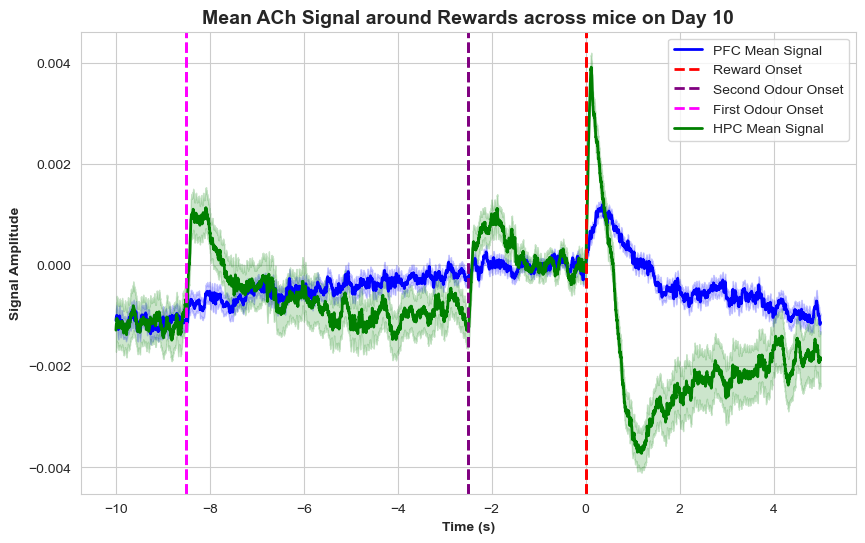

In [31]:
mouse_ids = ['maxwell_452', 'maxwell_453', 'maxwell_454']
days_of_interest = [12]
overlay = True

for day in days_of_interest:
    across_mice_analysis(mouse_ids, day, overlay)

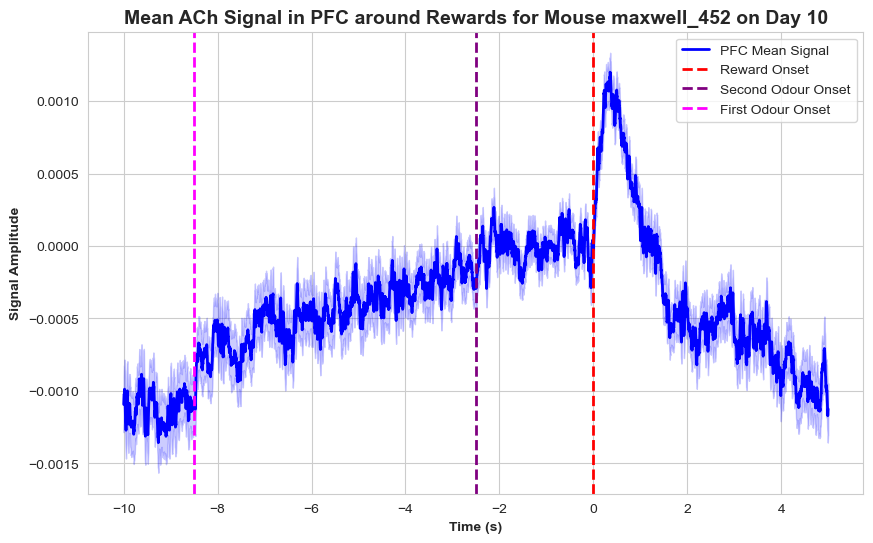

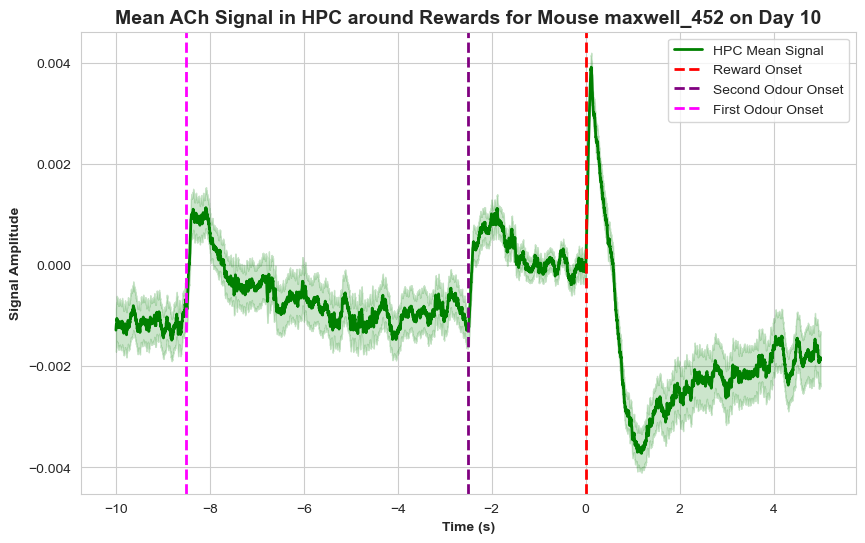

In [32]:
mouse_ids = ['maxwell_452', 'maxwell_453', 'maxwell_454']
days_of_interest = [12]
overlay = False

for day in days_of_interest:
    across_mice_analysis(mouse_ids, day, overlay)

# WE CAN ALSO PLOT JUST ONE MOUSE AND NOT OVERLAY THE SIGNALS

In [9]:
mouse_ids = ['maxwell_453']
days_of_interest = [12]
overlay = True

for day in days_of_interest:
    across_mice_analysis(mouse_ids, day, overlay)

# We can also plot signals across days

/var/folders/xc/fqjpc3c109d8130c9p4w179nnjty6s/T/ipykernel_67611/3694284966.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(days_of_interest))


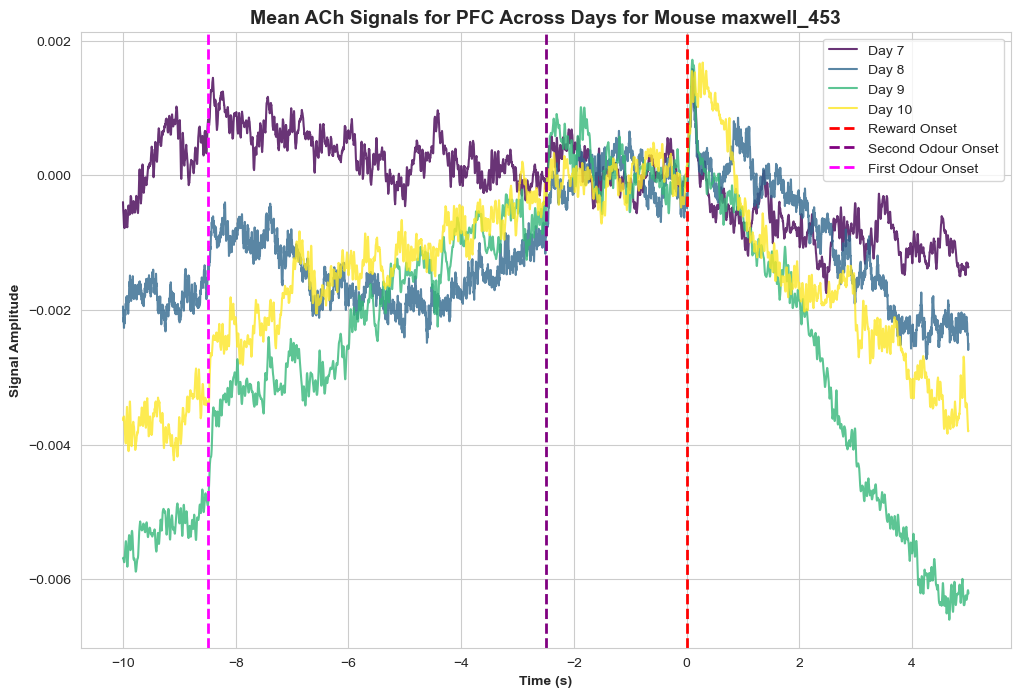

/var/folders/xc/fqjpc3c109d8130c9p4w179nnjty6s/T/ipykernel_67611/3694284966.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(days_of_interest))


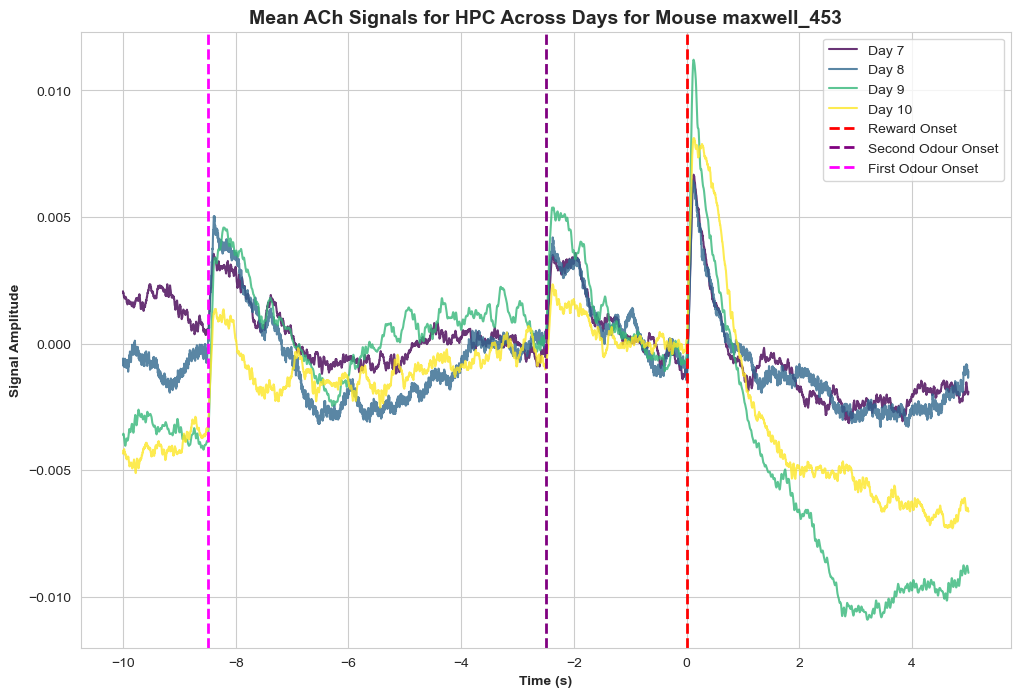

In [37]:
mouse_ids = ['maxwell_453']  # Single mouse
days_of_interest = np.arange(9,13)
area_of_interest = 'PFC'
plot_average_signals_across_days(mouse_ids, days_of_interest, area_of_interest)

mouse_ids = ['maxwell_453']  # Single mouse
days_of_interest = np.arange(9,13)
area_of_interest = 'HPC'
plot_average_signals_across_days(mouse_ids, days_of_interest, area_of_interest)

/var/folders/xc/fqjpc3c109d8130c9p4w179nnjty6s/T/ipykernel_67611/3694284966.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(days_of_interest))


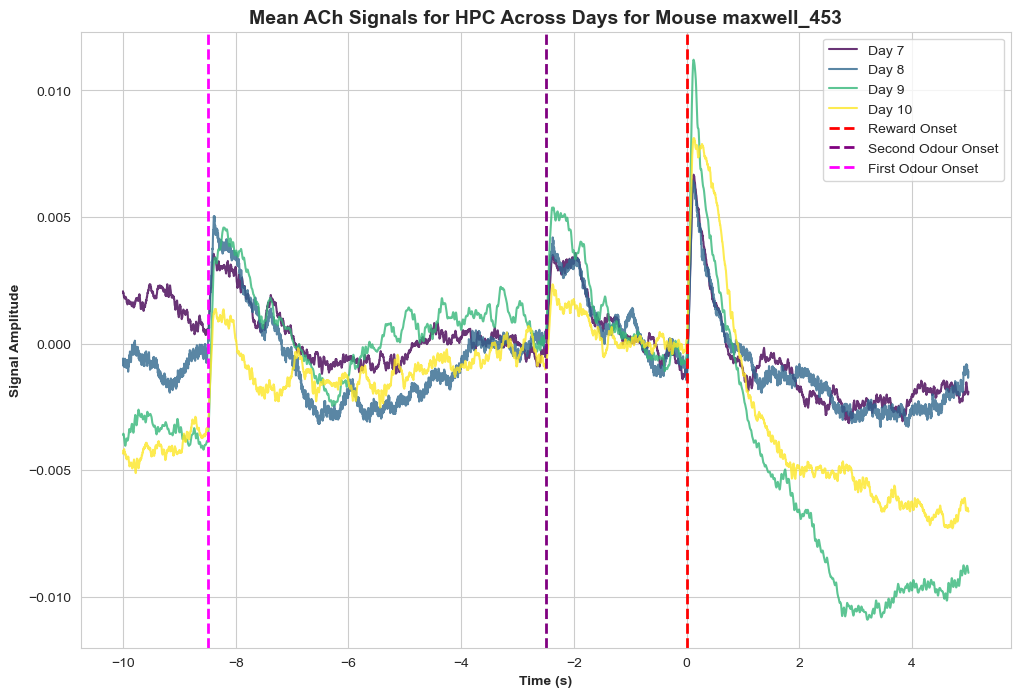

In [36]:
mouse_ids = ['maxwell_453']  # Single mouse
days_of_interest = np.arange(9,13)
area_of_interest = 'HPC'
plot_average_signals_across_days(mouse_ids, days_of_interest, area_of_interest)

In [6]:
mouse_ids = ['maxwell_452','maxwell_453','maxwell_454']
days_of_interest = range(3,11)
area_of_interest = 'HPC'
plot_average_signals_across_days(mouse_ids, days_of_interest, area_of_interest)


In [5]:
mouse_ids = ['maxwell_452','maxwell_453','maxwell_454']
days_of_interest = np.arange(3,10)
area_of_interest = 'PFC'
plot_average_signals_across_days(mouse_ids, days_of_interest, area_of_interest)
